In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "11_adv_problems/11c_scann_search.ipynb"
_nb_title = "임베딩 찾기"
_nb_message = """
이 노트북은 임베딩과 scaNN을 사용해 빠른 이미지 검색을 구현하는 법을 보인다.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/ychoi-kr/practical-ml-vision-book-ko/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=%EC%9E%84%EB%B2%A0%EB%94%A9+%EC%B0%BE%EA%B8%B0&download_url=https%3A%2F%2Fgithub.com%2Fychoi-kr%2Fpractical-ml-vision-book-ko%2Fraw%2Fmaster%2F11_adv_problems%2F11c_scann_search.ipynb"><img src="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book-ko/blob/master/11_adv_problems/11c_scann_search.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/11_adv_problems/11c_scann_search.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book-ko/master/11_adv_problems/11c_scann_search.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>임베딩 찾기</h1>
이 노트북은 임베딩과 scaNN을 사용해 빠른 이미지 검색을 구현하는 법을 보인다.


## GPU 활성화
이 저장소의 노트북들은 GPU를 사용하면 더 빨리 실행된다.

코랩에서:
* 수정 → 노트 설정 메뉴로 이동
* 하드웨어 가속기 드롭다운에서 GPU를 선택

Cloud AI Platform Notebooks에서:
* https://console.cloud.google.com/ai-platform/notebooks 로 이동
* GPU를 포함한 인스턴스를 생성하거나, 인스턴스를 선택하고 GPU를 추가

다음으로, 텐서플로로 GPU에 연결할 수 있는지 확인.

In [2]:
%pip install --quiet scann tensorflow-addons

     |████████████████████████████████| 10.5 MB 28.0 MB/s 
     |████████████████████████████████| 1.1 MB 53.5 MB/s 
     |████████████████████████████████| 588.3 MB 19 kB/s 
     |████████████████████████████████| 439 kB 51.4 MB/s 
     |████████████████████████████████| 6.0 MB 49.8 MB/s 
     |████████████████████████████████| 1.7 MB 69.6 MB/s 


In [3]:
import scann
import tensorflow as tf
import tensorflow_addons as tfa

print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    pass
    # raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.11.0
Found GPU at: /device:GPU:0


## 임베딩의 인덱스를 생성

사전 훈련된 모바일넷 모델을 사용해 꽃 데이터셋의 100개의 이미지의 임베딩을 생성.

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import scann
import os

# tensorflow_hub에서 압축된 모델을 로딩
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
BATCH_SIZE = 32
NUM_IMAGES = 100
NUM_NEIGH = 3 # top 3
CLASS_NAMES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


def read_and_decode(filename, reshape_dims=[IMG_HEIGHT, IMG_WIDTH]):
  # 파일 읽기
  img = tf.io.read_file(filename)
  # 압축된 문자열을 3D uint8 텐서로 변환.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_WIDTH, IMG_HEIGHT])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return filename, img, label, label_string

In [5]:
layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Flatten()
]
model = tf.keras.Sequential(layers, name='flowers_embedding')
print(model.summary())

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "flowers_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [6]:
def create_embeddings_dataset(embedder, csvfilename, num_images):
  ds = (tf.data.TextLineDataset(csvfilename).
        map(decode_csv).take(num_images).batch(BATCH_SIZE))
  dataset_filenames = []
  dataset_embeddings = []
  for filenames, images, _, _ in ds:
    embeddings = embedder(images)
    dataset_filenames.extend([f.numpy().decode('utf-8') for f in filenames])
    dataset_embeddings.extend(embeddings)
  dataset_embeddings = tf.convert_to_tensor(dataset_embeddings)
  return dataset_filenames, dataset_embeddings

dataset_filenames, dataset_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv", NUM_IMAGES
)
print(dataset_filenames[:3])
print(dataset_embeddings.shape) # (NUM_IMAGES, 1280)이 되어야 함

1/1 [==============================] - 1s 996ms/step
['gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg', 'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg', 'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg']
(100, 1280)


In [7]:
query_filenames, query_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv", 2
)
print(query_embeddings.shape)

1/1 [==============================] - 0s 325ms/step
(2, 1280)


In [8]:
## SCaNN 검색기를 생성
searcher = scann.scann_ops.builder(dataset_embeddings, NUM_NEIGH, "dot_product").score_ah(2).build()

In [9]:
neighbors, distances = searcher.search_batched(query_embeddings)
print(neighbors)
print(distances)

tf.Tensor(
[[36 42 11]
 [95 26 27]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[390.55447 379.76324 356.11118]
 [457.37067 362.77005 336.50104]], shape=(2, 3), dtype=float32)


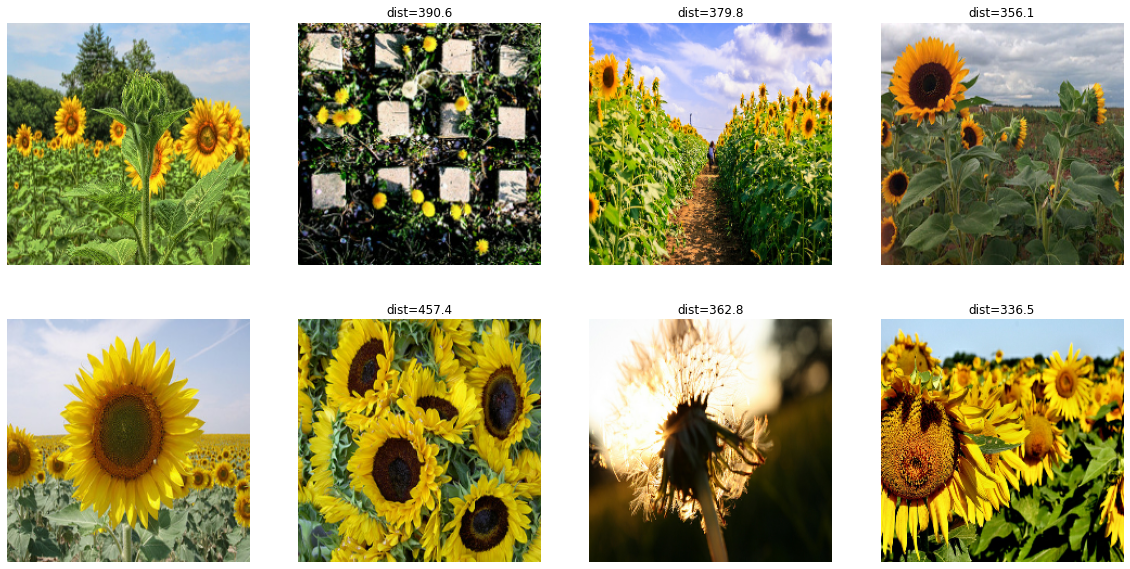

In [10]:
f, ax = plt.subplots(len(query_filenames), NUM_NEIGH + 1,
                     figsize=(5 * (1 + NUM_NEIGH), 5 * len(query_filenames)))
for rowno, query_filename in enumerate(query_filenames):
  ax[rowno][0].imshow(read_and_decode(query_filename).numpy())
  ax[rowno][0].axis('off')
  for colno, neigh in enumerate(neighbors[rowno]):
    ax[rowno][colno+1].imshow(read_and_decode(dataset_filenames[neigh]).numpy())
    ax[rowno][colno+1].set_title('dist={:.1f}'.format(distances[rowno][colno].numpy()))
    ax[rowno][colno+1].axis('off')

## 삼중항 손실

분류 과업에 기반한 임베딩을 훈련한다.
분류가 아니라 임베딩이 목적이므로, 삼중항 손실, 특히 세미하드 삼중항을 이용한다.

참고:
* https://arxiv.org/pdf/1503.03832.pdf
* https://www.tensorflow.org/addons/tutorials/losses_triplet
* https://omoindrot.github.io/triplet-loss

참고:
삼중항 손실은 *각* 배치에 양수 쌍이 없으면 NaN으로 끝나는 식으로 정의된다.
이러한 일이 발생하지 않도록 배치 크기가 충분히 커야 한다.

In [11]:
layers = [
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(5, activation=None, name='dense_5'),
      tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='normalize_embeddings')
]
model = tf.keras.Sequential(layers, name='flowers_embedding')
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=tfa.losses.TripletSemiHardLoss())
print(model.summary())

Model: "flowers_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_embedding (KerasL  (None, 1280)             2257984   
 ayer)                                                           
                                                                 
 dense_5 (Dense)             (None, 5)                 6405      
                                                                 
 normalize_embeddings (Lambd  (None, 5)                0         
 a)                                                              
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [12]:
# 전체 데이터셋이 아닌 32*10개의 이미지에 대해 훈련
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
    map(decode_csv)).take(BATCH_SIZE*10).map(lambda path, img, lint, ls: (img, lint)).batch(BATCH_SIZE)
history = model.fit(train_dataset, epochs=5)

Epoch 1/5
10/10 [==============================] - 146s 14s/step - loss: 0.9267
Epoch 2/5
10/10 [==============================] - 99s 10s/step - loss: 0.8385
Epoch 3/5
10/10 [==============================] - 124s 13s/step - loss: 0.7563
Epoch 4/5
10/10 [==============================] - 100s 10s/step - loss: 0.6862
Epoch 5/5
10/10 [==============================] - 72s 7s/step - loss: 0.6150


In [13]:
# 새 모델을 가지고 반복
dataset_filenames, dataset_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv", NUM_IMAGES
)
print(dataset_filenames[:3])
print(dataset_embeddings.shape) # (NUM_IMAGES, 5)가 되어야 함

query_filenames, query_embeddings = create_embeddings_dataset(
    lambda x: model.predict(x),
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv", 2
)
print(query_embeddings.shape)

1/1 [==============================] - 0s 439ms/step
['gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg', 'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg', 'gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/284497199_93a01f48f6.jpg']
(100, 5)
1/1 [==============================] - 0s 36ms/step
(2, 5)


In [14]:
searcher = scann.scann_ops.builder(dataset_embeddings, NUM_NEIGH, "dot_product").score_ah(2).build()
neighbors, distances = searcher.search_batched(query_embeddings)
print(neighbors)
print(distances)

tf.Tensor(
[[71 41 27]
 [72 49 41]], shape=(2, 3), dtype=int32)
tf.Tensor(
[[0.95830345 0.745896   0.73107684]
 [0.91910607 0.91346735 0.8401644 ]], shape=(2, 3), dtype=float32)


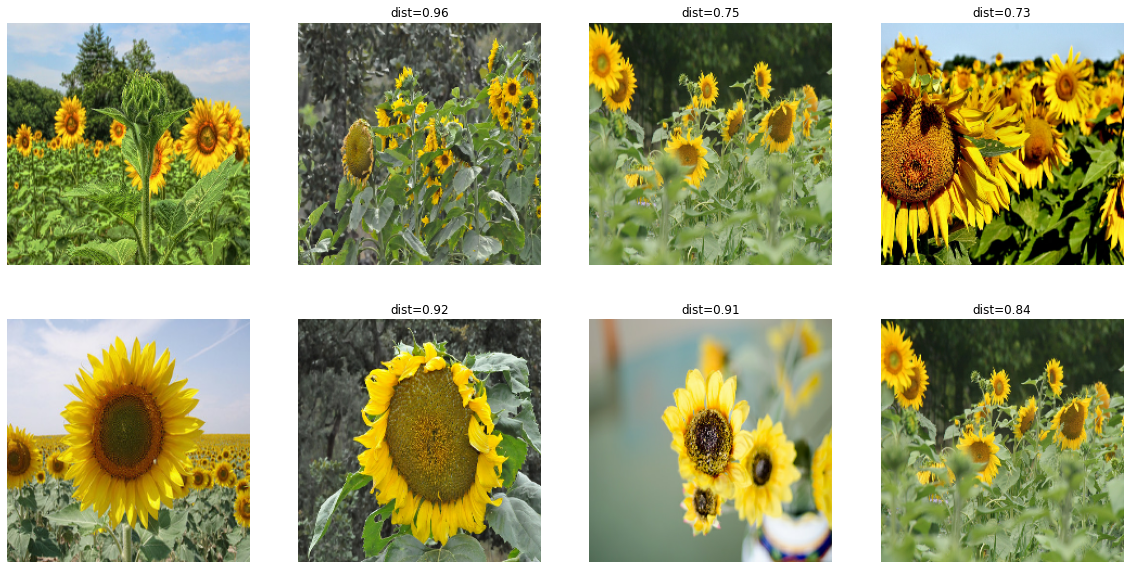

In [15]:
f, ax = plt.subplots(len(query_filenames), NUM_NEIGH + 1,
                     figsize=(5 * (1 + NUM_NEIGH), 5 * len(query_filenames)))
for rowno, query_filename in enumerate(query_filenames):
  ax[rowno][0].imshow(read_and_decode(query_filename).numpy())
  ax[rowno][0].axis('off')
  for colno, neigh in enumerate(neighbors[rowno]):
    ax[rowno][colno+1].imshow(read_and_decode(dataset_filenames[neigh]).numpy())
    ax[rowno][colno+1].set_title('dist={:.2f}'.format(distances[rowno][colno].numpy()))
    ax[rowno][colno+1].axis('off')

## 프로젝터에서 임베딩을 보기

https://projector.tensorflow.org/ 에서 볼 파일들을 생성

In [16]:
import io
import tensorflow_datasets as tfds

test_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
    map(decode_csv)).map(lambda path, img, lint, ls: (img, lint)).take(NUM_IMAGES).batch(1)
test_results = model.predict(test_dataset)
np.savetxt("vecs.tsv", test_results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(CLASS_NAMES[x] + "\n") for x in labels]
out_m.close()

100/100 [==============================] - 48s 463ms/step


<img width="600" src="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/11_adv_problems/embedding_projection.png?raw=1" />

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.